In [1]:
import control as ct, numpy as np, matplotlib.pyplot as plt, re
from json import load, dump

# Funções de transferência do controlador PID discreto:
# $$G_c(z) = K_p + \frac{K_i}{1-z^{-1}} + K_d\cdot(1-z^-1)$$

# $$G_c(z) = K_C \cdot \frac{(z-z_{c1})\cdot(z-z_{c2})}{z\cdot(z-1)}$$

In [2]:
def create_servo(k, tau):
    return k*ct.tf(1, [1, 0])*ct.tf(1, [tau, 1])

In [3]:
def plot_response(sys, t, u, grid_major = 1, grid_minor = 0.2, display = True):
    response = ct.forced_response(ct.feedback(sys), t, u)
    if display:
        plt.grid()
        plt.plot(response.time, response.outputs)
        plt.show()
    return response

In [4]:
def compare_step(sys1, sys2, time, y_min = None, y_max = None):
    step = np.ones(len(time))
    resp1 = plot_response(sys1, time, step, display=False)
    resp2 = plot_response(sys2, time, step, display=False)
    plt.grid()
    plt.plot(resp1.time, resp1.outputs, c='r', label="Não compensado")
    plt.plot(resp2.time, resp2.outputs, c='b', label="Compensado")
    plt.legend()
    if y_min != None:
        plt.ylim(bottom=y_min)
    if y_max != None:
        plt.ylim(top=y_max)
    plt.show()
    return resp1, resp2

In [5]:
def design_discrete_pid(*, sys, csi=None, ts=None, pole=None, overshoot=None, T=1e-3, theta=-3, verbose=False):
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    elif pole != None:
        dom_s = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    if verbose:
        print("Polo dominante escolhido: {dom_s:.2f}")
    dom_z = np.e**(T*dom_s)
    sigma = dom_z.real
    omega = dom_z.imag
    gz = ct.c2d(sys, T)
    zc1 = np.sort(gz.poles())[-2]
    tan = np.tan(np.deg2rad(theta))
    zc2 = (tan*(np.abs(dom_z)**2-sigma)+omega)/(omega+tan*(sigma-1))
    gc_num = np.convolve([1, -zc1], [1, -zc2])
    gc_den = np.convolve([1, 0], [1, -1])
    gc = ct.tf(gc_num, gc_den, T)
    series = gz*gc
    kc = 1/np.abs(series(dom_z))
    return gz, kc*gc

In [6]:
def design_lead_cancel(*, sys, csi=None, ts=None, pole=None, overshoot=None, verbose=False):
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    elif pole != None:
        dom_s = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    if verbose:
        print(f"Polo dominante escolhido: {dom_s:.2f}")
    zc = np.sort(sys.poles()[np.abs(sys.poles()) > 10e-5])[0] # zero = polo mais próximo da origem sem ser 0
    current_angle = 0
    for p in sys.poles()[sys.poles() != zc]:
        current_angle += np.angle(dom_s - p)
    for z in sys.zeros():
        current_angle += np.angle(dom_s - z)

    pole_angle = np.pi - current_angle
    if pole_angle < np.pi/2: # polo do compensador à esquerda do polo dominante
        pc = dom_s.real - dom_s.imag/np.tan(pole_angle)
    else: # polo do compensador à direita do compensador
        pc = dom_s.real + dom_s.imag/np.tan(pole_angle)
    gc = ct.tf([1, -zc], [1, -pc])
    k = 1/np.abs((gc*sys)(dom_s))
    return sys, k*gc

In [7]:
def design_lead_bissect(*, sys, csi=None, ts=None, pole=None, overshoot=None, verbose=False):
    if csi != None and ts != None:
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    elif pole != None:
        dom_s = pole
    elif overshoot != None and ts != None:
        csi = -np.log(overshoot)/np.sqrt(np.pi**2+np.log(overshoot)**2)
        omega_n = 4/(ts*csi)
        omega_d = omega_n * np.sqrt(1-csi**2)
        dom_s = -csi*omega_n + 1j*omega_d
    else:
        raise Exception(ValueError)
    if verbose:
        print(f"Polo dominante escolhido: {dom_s:.2f}")
    current_angle = 0
    for p in sys.poles():
        current_angle += np.angle(dom_s - p)

    for z in sys.zeros():
        current_angle += np.angle(dom_s - z)
    
    # resolvendo para zc e pc
    phi = np.abs(np.pi - current_angle)
    alpha = np.angle(dom_s) - np.pi/2
    beta = np.pi/2 - alpha
    gamma = np.pi - beta
    theta = np.pi - beta - (gamma+phi)/2
    eta = np.pi - beta - (gamma-phi)/2
    pc = -np.abs(dom_s)*np.sin((gamma+phi)/2)/(np.sin(theta))
    zc = -np.abs(dom_s)*np.sin((gamma-phi)/2)/(np.sin(eta))
    
    gc = ct.tf([1, -zc], [1, -pc])
    k = 1/np.abs((gc*sys)(dom_s))
    
    return sys, k*gc
    

In [8]:
def z2t(sys, out_prefix = "uN", in_prefix = "errN"):

    out = [{
            "coef": coef,
            "iter": i
        } for i, coef in enumerate(sys.den[0][0].real) if coef != 0]
    
    inp = [{
            "coef": coef,
            "iter": i
        } for i, coef in enumerate(sys.num[0][0].real) if coef != 0]
    
    if len(inp) < len(out):
        for entry in inp:
            entry["iter"] += 1

    lhs = (str(out[0]["coef"])+'*' if out[0]["coef"] != 1 else "") + out_prefix + "_" + str(out[0]["iter"])

    rhs = ""
    for term in out[1:]:
        rhs += str("{0:+}".format(-term["coef"])) + f"*{out_prefix}_{term['iter']} "

    for term in inp:
        rhs += str("{0:+}".format(term["coef"])) + f"*{in_prefix}_{term['iter']} "

    return (lhs + " = " + rhs).replace("= +", "= ").replace(" +", " + ").replace(" -", " - ").strip()

In [9]:
def s2t(sys, out_prefix = "u", in_prefix = "err"):

    out = [{
            "coef": coef,
            "diff": i
        } for i, coef in enumerate(reversed(sys.den[0][0])) if coef != 0]
    
    inp = [{
            "coef": coef,
            "diff": i
        } for i, coef in enumerate(reversed(sys.num[0][0])) if coef != 0]

    if len(inp) > len(out):
        for entry in inp:
            entry["diff"] += 1

    lhs = (str(out[0]["coef"])+'*' if out[0]["coef"] != 1 else "") + out_prefix + "_" + str(out[0]["diff"])
    rhs = ""
    for term in out[:-1]:
        rhs += str("{0:+}".format(-term["coef"])) + f"*{out_prefix}_{term['diff']} "

    for term in inp:
        rhs += str("{0:+}".format(term["coef"])) + f"*{in_prefix}_{term['diff']} "
    return (lhs + " = " + rhs).strip()

In [10]:
def settling_time(sys, time, set_pct=4):
    response = ct.forced_response(ct.feedback(sys), time, np.ones(len(time)))
    final_value = response.outputs[-1]
    settling_range = final_value * set_pct / 100

    for i, out in enumerate(reversed(response.outputs)):
        if abs(out-final_value) >= settling_range:
            return time[len(time)-i+1]

    return None

In [11]:
k = 735
tau = 0.055
T = 1e-3
csi = 0.4256
overshoot = 0.2
ts = 0.3

t_max = 0.6
y_min = 0
time = np.arange(0, t_max, T)
step = np.ones(len(time))

servo = create_servo(k=k, tau=tau)
servo

TransferFunction(array([735.]), array([0.055, 1.   , 0.   ]))

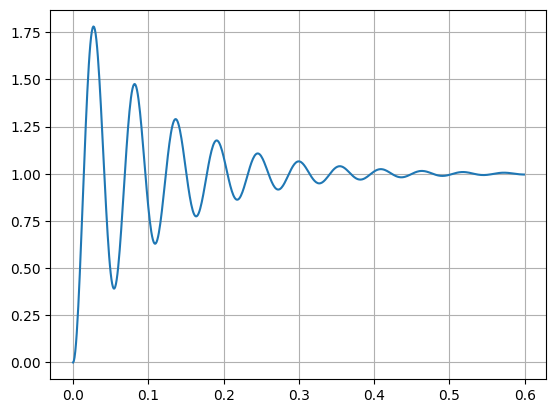

In [12]:
resp = plot_response(servo, time, step)

### Controle PID discreto

In [13]:
g, gc = design_discrete_pid(sys=servo, overshoot=overshoot, ts=ts, T=T)
gc

TransferFunction(array([ 2.23641231+0.j, -4.42878256+0.j,  2.19243777+0.j]), array([ 1, -1,  0]), 0.001)

/home/nikolas/.local/lib/python3.10/site-packages/control/statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


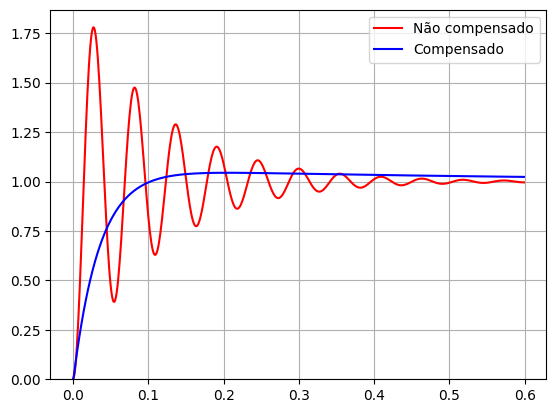

In [14]:
_ = compare_step(servo, g*gc, time, y_min=y_min)

# Função de transferência do compensador por avanço de fase:
# $$G_c(s) = K\cdot\frac{s+z_c}{s+p_c}$$

### Compensador por avanço de fase (cancelamento polo-zero)

In [15]:
g, gc = design_lead_cancel(sys=servo, overshoot=overshoot, ts=ts)
gc

TransferFunction(array([0.06399098+0.j, 1.16347232+0.j]), array([ 1.        , 26.66666667]))

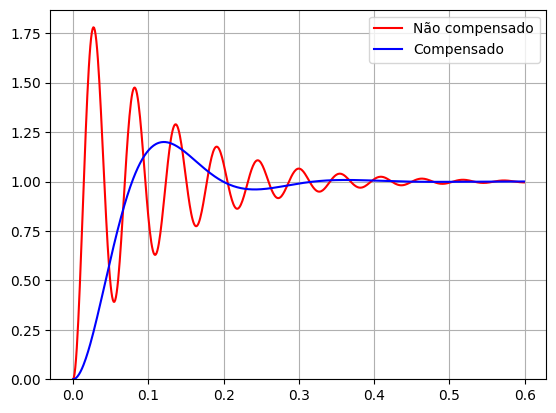

In [16]:
_ = compare_step(g, gc*g, time, y_min=y_min)

### Compensandor por avanço de fase (método da bissecção)

In [17]:
g, gc = design_lead_bissect(sys=servo, overshoot=overshoot, ts=ts)
gc

TransferFunction(array([0.06925597, 1.69410862]), array([ 1.      , 34.959028]))

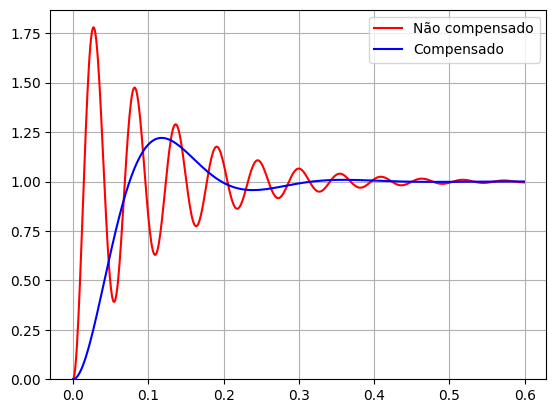

In [18]:
_ = compare_step(servo, g*gc, time, y_min=y_min)

### Motor panorâmico

In [19]:
path = "../system_parameters/"
with open(f"{path}motor_pan.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [20]:
pan = create_servo(K, tau)
pan

TransferFunction(array([0.63711187]), array([0.19910298, 1.        , 0.        ]))

In [21]:
_, gc_pan = design_lead_bissect(sys=pan, overshoot=0.1, ts = 2)
gc_pan

TransferFunction(array([ 4.7763887 , 14.56580724]), array([1.        , 3.75337806]))

In [22]:
gz_pan = ct.c2d(gc_pan, 5e-3)
gz_pan

TransferFunction(array([ 4.7763887, -4.7042388]), array([ 1.        , -0.98140811]), 0.005)

In [23]:
time = np.arange(0, 5, 1e-3)

In [24]:
print(f"Tempo de acomodação (1%) do sistema não compensado: {settling_time(pan, time, 1)} s")
print(f"Tempo de acomodação (1%) do sistema compensado: {settling_time(gc_pan*pan, time, 1)} s")

Tempo de acomodação (1%) do sistema não compensado: 4.611 s
Tempo de acomodação (1%) do sistema compensado: 0.979 s


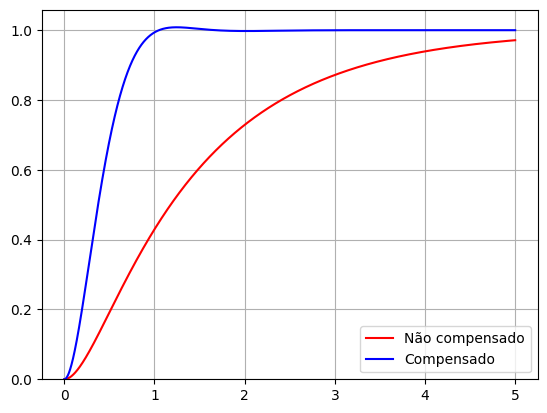

In [25]:
_ = compare_step(pan, gc_pan*pan, time, y_min=y_min)

In [26]:
diff_eq = z2t(gz_pan)
print(diff_eq)

with open("../system_parameters/controller_pan.info", "w") as file:
    consts = {}
    for i, n in enumerate([float(n.replace(" ", "")) for n in re.findall(r"[-]?\s?\d+\.?\d+", diff_eq)]):
        consts[f"c{i+1}"] = n
    dump(consts, file)

uN_0 = 0.9814081113269162*uN_1 + 4.776388699217659*errN_0 - 4.704238795256313*errN_1


### Motor tilt

In [27]:
path = "../system_parameters/"
with open(f"{path}motor_tilt.info", "r") as file:
    params = load(file)
tau, K = params["tau"], params["K"]

In [28]:
tilt = create_servo(K, tau)
tilt

TransferFunction(array([0.51204194]), array([0.14841093, 1.        , 0.        ]))

In [29]:
_, gc_tilt = design_lead_bissect(sys=tilt, overshoot=0.1, ts = 2)
gc_tilt

TransferFunction(array([ 6.64536743, 18.13920419]), array([1.        , 4.19331972]))

In [30]:
gz_tilt = ct.c2d(gc_tilt, 5e-3)
gz_tilt

TransferFunction(array([ 6.64536743, -6.5556156 ]), array([ 1.        , -0.97925167]), 0.005)

In [31]:
time = np.arange(0, 5, 1e-3)

In [32]:
print(f"Tempo de acomodação (1%) do sistema não compensado: {settling_time(tilt, time, 1)} s")
print(f"Tempo de acomodação (1%) do sistema compensado: {settling_time(gc_tilt*tilt, time, 1)} s")

Tempo de acomodação (1%) do sistema não compensado: 4.769 s
Tempo de acomodação (1%) do sistema compensado: 2.221 s


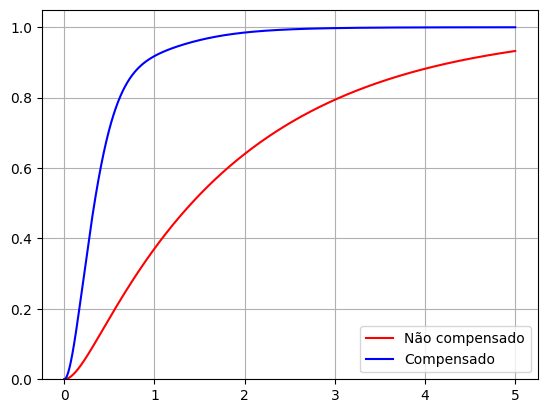

In [33]:
_ = compare_step(tilt, gc_tilt*tilt, time, y_min=y_min)

In [34]:
diff_eq = z2t(gz_tilt)
print(diff_eq)

with open("../system_parameters/controller_tilt.info", "w") as file:
    consts = {}
    for i, n in enumerate([float(n.replace(" ", "")) for n in re.findall(r"[-]?\s?\d+\.?\d+", diff_eq)]):
        consts[f"c{i+1}"] = n
    dump(consts, file)

uN_0 = 0.979251672405997*uN_1 + 6.645367432868703*errN_0 - 6.5556155951564*errN_1
